## Data preparation

### Load Data & Transform

Load data from file './real_hands' and applying normalization for the transform.

In [17]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [file for file in os.listdir(directory) if file.endswith('.jpeg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.images[idx])
        image = Image.open(img_path)# .convert('RGB')  # Convert to RGB if needed

        if self.transform:
            image = self.transform(image)

        return image

bs = 32

transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean=(0), std=(1))])

train_dataset = CustomImageDataset(directory='./real_hands', transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)

### Image Enhancement

The code in the cell below is used for image enhancement, flipping the pictures in the data set horizontally, thereby doubling the number of pictures in the data set. The reason is that the number of data in this data set is small, only 8000. You can run it if you want to do image enhancement.

In [2]:
# import os
# from PIL import Image
# from torchvision import transforms
# from torch.utils.data import Dataset, DataLoader

# class CustomImageDataset(Dataset):
#     def __init__(self, directory, transform=None):
#         self.directory = directory
#         self.transform = transform
#         self.images = [file for file in os.listdir(directory) if file.endswith('.jpeg')]
#         self.augment_flip = transforms.RandomHorizontalFlip(p=1)

#     def __len__(self):
#         return len(self.images) * 2

#     def __getitem__(self, idx):
#         original_idx = idx // 2
#         is_augmented = idx % 2 == 1

#         img_path = os.path.join(self.directory, self.images[original_idx])
#         image = Image.open(img_path)

#         if self.transform:
#             image = self.transform(image)

#         if is_augmented:
#             image = self.augment_flip(image)

#         return image

# bs = 32

# transform = transforms.Compose([transforms.ToTensor(),
#     transforms.Normalize(mean=(0), std=(1))])

# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = CustomImageDataset(directory='./real_hands', transform=transform)
# train_loader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)


### Inspect Dataset
You can see the details about the data that we load, such as the Batch Size, Number, and sample image, etc,

Batch size: 32
Number of batches: 250
Num images: 8000

Image shape: torch.Size([32, 1, 32, 32])
Num pixels: 1024
Range: max, 1.0 min,0.0


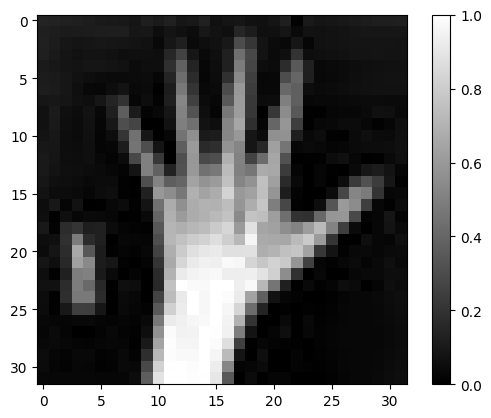

In [18]:
import matplotlib.pyplot as plt

print(train_loader)
print('Batch size: '+str(train_loader.batch_size))
print('Number of batches: '+str(train_loader.__len__()))
print('Num images: '+str(train_loader.batch_size*train_loader.__len__()))
print()

images = next(iter(train_loader))

print('Image shape: '+str(images.shape))
plt.imshow(images[0][0].squeeze(), 'gray')
plt.colorbar()

print('Num pixels: '+str(images.shape[2]*images.shape[3]))
print('Range: max, '+str(float(images.max()))+' min,'+str(float(images.min())))


### Module Import & Random Seed Set
Most of the import work is done here and also with the random seed part to make sure the random situation can be reproduce. Also a check for gpu/cpu.

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
# device = 'mps'  # This is for m series chip MAC only!

No GPU available!


## Network design and implementation

The following is the network that is used in the final version. Other process verion network is shown in the hypertune notebook.

In [20]:
class Generator(nn.Module):
    def __init__(self, g_input_dim=100, g_output_dim=32*32):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, 128 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = x.view(-1, 32*32)
        return x




class Discriminator(nn.Module):
    def __init__(self, d_input_dim=32*32):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 1)
        
    def forward(self, x):
        x = x.view(-1, 1, 32, 32)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(-1, 128 * 8 * 8)
        x = torch.sigmoid(self.fc1(x))
        return x




    
G = Generator().to(device)
D = Discriminator().to(device)


The generator is consist of three layers: a linear full connection layer and two transpose conv layers.

In [21]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=8192, bias=True)
  (conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

The discriminator is consist of three layers: two conv layers and a linear full connection layer.

In [22]:
D

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=1, bias=True)
)

The loss function is define here and also with the learning rate.

There is also another option for dynamic learning rate optimiser can be used.

In [23]:

criterion = nn.BCELoss()
z_dim = 100


# Optimiser 1: Original optimiser

glr = 0.0001
dlr = 0.00009
G_optimizer = torch.optim.Adam(G.parameters(), lr = glr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = dlr)


# Optimiser 2: Dyamic Learning rate changing optimiser

# G_optimizer = torch.optim.Adam(G.parameters(), lr=glr, betas=(0.9, 0.999))
# D_optimizer = torch.optim.Adam(D.parameters(), lr=dlr, betas=(0.9, 0.999))
# G_scheduler = torch.optim.lr_scheduler.StepLR(G_optimizer, step_size=500, gamma=0.999)
# D_scheduler = torch.optim.lr_scheduler.StepLR(D_optimizer, step_size=500, gamma=0.999)



## Training and evaluation loops

This part is the function to train Discriminator and Generator!

In [24]:
def D_train(x):

    D.train()
    D_optimizer.zero_grad()
    x_real, y_real = x.view(-1, 32*32), torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)
    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z), torch.zeros(bs, 1).to(device)
    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()

    return  D_loss.data.item()

In [25]:
def G_train(x):

    G.train()
    G_optimizer.zero_grad()
    z = torch.randn(bs, z_dim).to(device)
    G_output = G(z)
    D_output = D(G_output)
    y = torch.ones(bs, 1).to(device)
    G_loss = criterion(D_output, y)
    G_loss.backward()
    G_optimizer.step()

    return G_loss.data.item()

## Network training
Use the best hyperparameters and network design here (and justify briefly your choices, linking them to the `yourusername_DLcw1_hypertune.ipynb` notebook.

Show loss evolution with livelossplot or any other graphic visualisation tool of your choice

Use following code to train the network, It may cost about 100 minutes. And the corresponding Liveloss figure will show up and update!

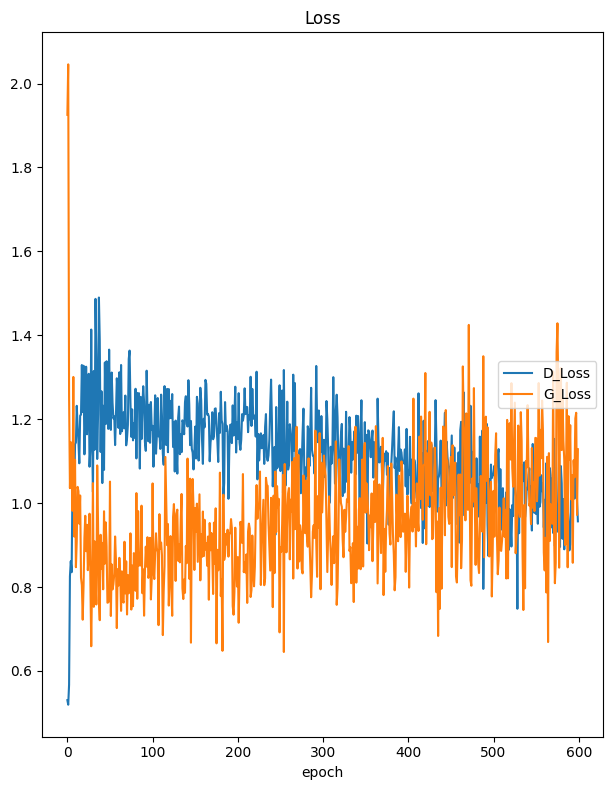

Loss
	D_Loss           	 (min:    0.520, max:    1.490, cur:    0.957)
	G_Loss           	 (min:    0.645, max:    2.046, cur:    1.128)


In [ ]:
import numpy as np

n_epoch = 600 # about 102 minutes
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
  D_losses, G_losses = [], []
  logs = {}
  for batch_idx, (x) in enumerate(train_loader):
    logs['D_Loss'] = D_train(x)
    logs['G_Loss'] = G_train(x)
  liveloss.update(logs)
  liveloss.draw()

  # save every 20th epochs
  if(np.mod(epoch, 10) == 0):
    torch.save(G.state_dict(), "./Generator_norm_{:03d}.pth".format(epoch))

## Generate 300 new samples with your trained network

Use the following cell to generate image by loaded the choisen Generator model!

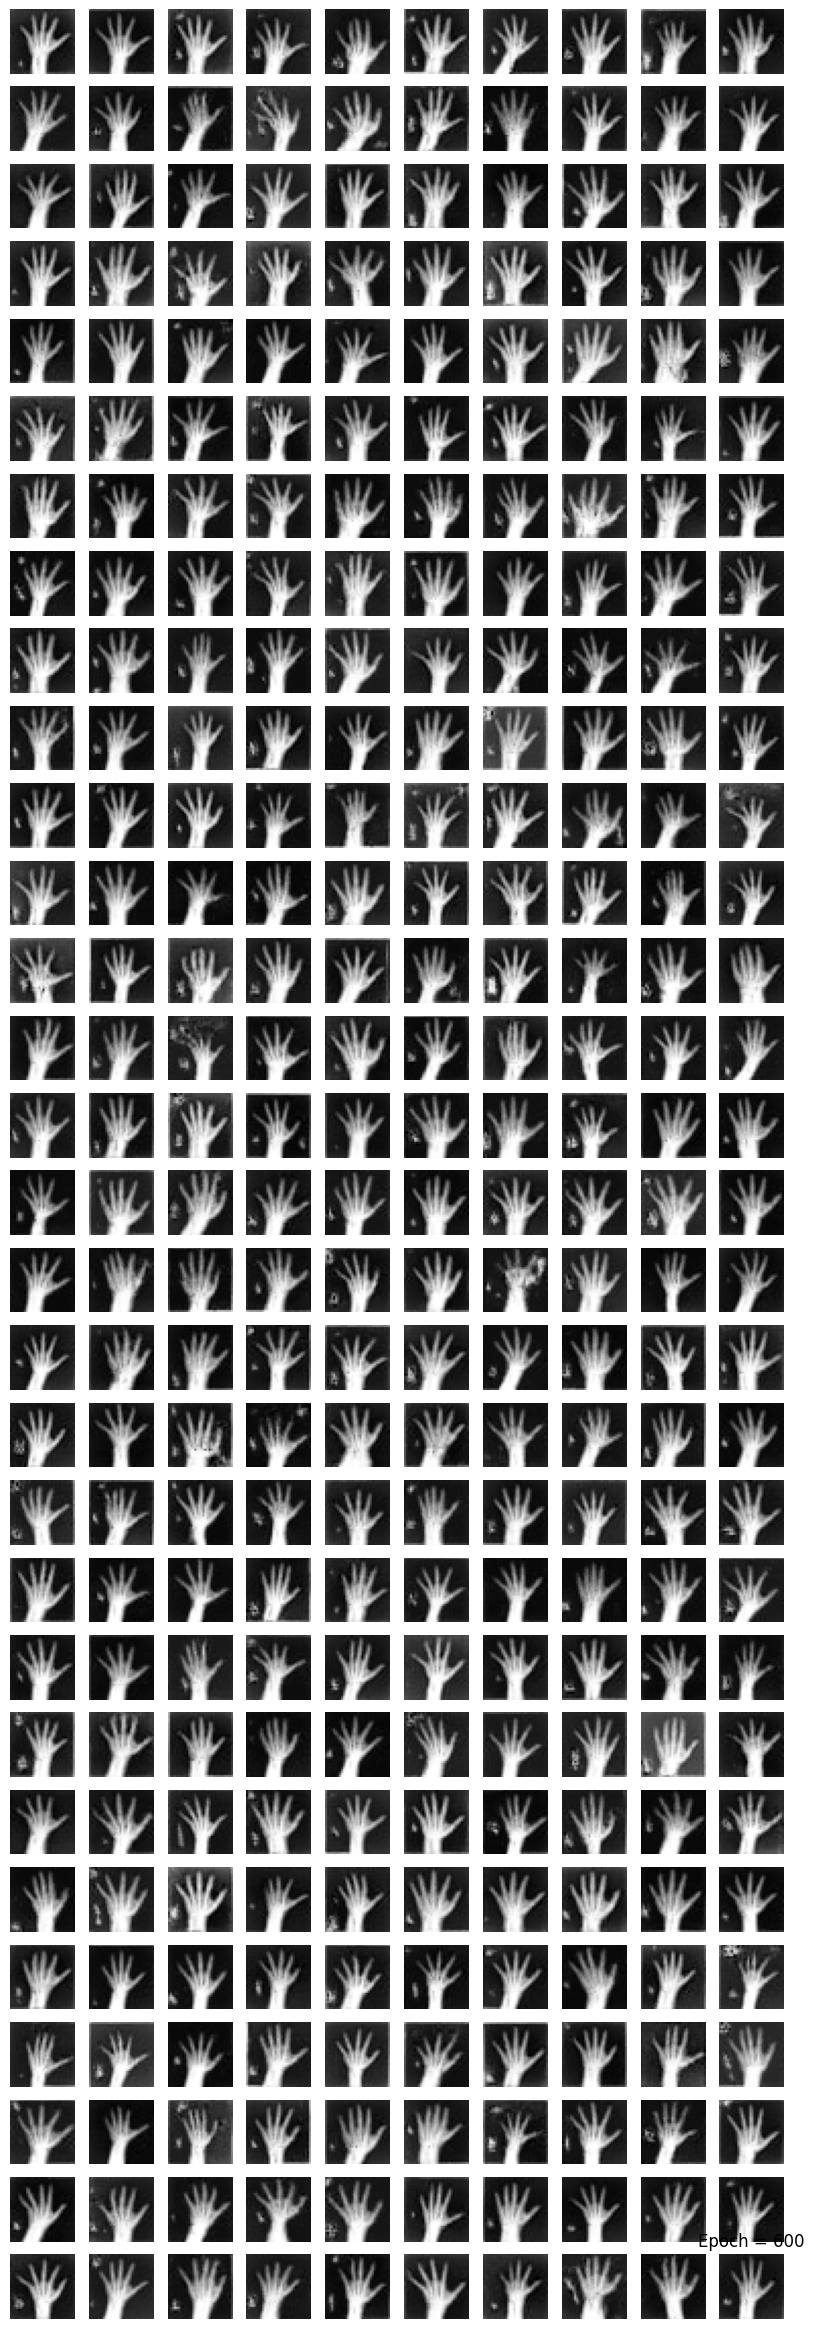

In [26]:
num = 300
set_seed(0)

epoch = 600
G.load_state_dict(torch.load("./Generator_norm_{:03d}.pth".format(epoch)))

with torch.no_grad():
    test_z = torch.randn(num, z_dim).to(device)
    generated = G(test_z)

saved_images = generated.view(generated.size(0), 1, 32, 32).cpu()

fig, axarr = plt.subplots(30, 10, figsize=(10, 30))
for ax, img in zip(axarr.flatten(), saved_images):
    ax.axis('off')
    ax.imshow(img.squeeze(), cmap="gray")
plt.title('Epoch = {:03d}'.format(epoch))
plt.show()


## Save the 300 generated samples as `.jpeg` files
The format of the saved samples should be `.jpeg`, and the names of the files should be:
- `yourusername_VAE001.jpeg`, `yourusername_VAE002.jpeg`, ... , `yourusername_VAE300.jpeg`

or

- - `yourusername_GAN001.jpeg`, `yourusername_GAN002.jpeg`, ... , `yourusername_GAN300.jpeg`

You can save your samples in your Google Drive or your local machine and then copy them to the repo where you will submit the answer.

Use the following cell to save the generated images into files with the corresponding name!

In [28]:
from torchvision.utils import save_image
import os

save_dir = './GAN_hands'
os.makedirs(save_dir, exist_ok=True)

with torch.no_grad():
    test_z = torch.randn(num, z_dim).to(device)
    generated = G(test_z)

    for i, img in enumerate(generated):
        filename = f'GAN{str(i+1).zfill(3)}.jpeg'
        save_image(img.view(1, 32, 32), os.path.join(save_dir, filename))


All works done here!